In [2]:
%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [7]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
import operator
from typing import Annotated


In [8]:
class State(TypedDict):
  question : str
  answer: str
  context : Annotated[list, operator.add]

In [9]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [10]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

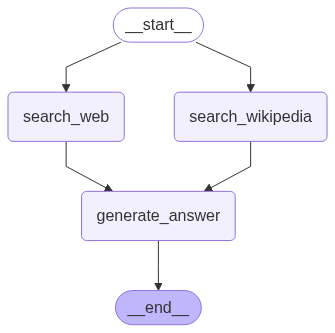

In [13]:
def search_web(state):
  """ Retrieve docs from web search """
  tavily_search = TavilySearchResults(max_results = 3)
  search_docs = tavily_search.invoke(state['question'])

  # Format
  formatted_search_docs = "\n\n---\n\n".join(
      [
          f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
          for doc in search_docs
      ]
  )

  return {"context": [formatted_search_docs]}

def search_wikipedia(state):

    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'],
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def generate_answer(state):

  context = state["context"]
  question = state["question"]

  answer_template = """Answer this question {question} using this context {context}"""
  answer_instructions = answer_template.format(question = question ,
                                               context = context)

  answer = llm.invoke([SystemMessage(content = answer_instructions)]+[HumanMessage(content = "Answer the question")])

  return {"answer" : answer}


builder = StateGraph(State)

builder.add_node("search_web", search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "search_web")
builder.add_edge(START, "search_wikipedia")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("search_wikipedia","generate_answer")
builder.add_edge("generate_answer",END)

graph = builder.compile()
graph


In [15]:
result = graph.invoke({"question":"Who should be held responsible for the recent stampede in Bangalore during the celebration"})
result["answer"].content

'The recent stampede in Bangalore during the RCB victory celebration has led to various parties pointing fingers at the Karnataka state government. Union Minister H D Kumaraswamy and BJP national spokesperson Sambit Patra have held the Congress government in Karnataka, specifically Chief Minister Siddaramaiah and Deputy Chief Minister DK Shivakumar, responsible for the incident. They have criticized the government for a lack of proper planning and precautionary measures. The Karnataka BJP President BY Vijayendra also stated that the state government should take full responsibility for the tragedy, citing inadequate preparations for the event. Additionally, IPL Chairman Arun Dhumal mentioned that the Board of Control for Cricket in India (BCCI) had no knowledge of the RCB celebrations, suggesting that the responsibility lies with the local administration.'

In [16]:
result = graph.invoke({"question":"Is Virat Kohli is to be blamed? Since it was because of him fans came in so huge crowds and because he wanted to go urgently to  London next morning?"})
result["answer"].content

'Based on the provided context, it seems that Virat Kohli is being criticized for his actions during a cricket match, particularly for engaging with the crowd in a way that some perceived as "classless." However, the context also suggests that it might be unfair to place the blame solely on him for the large crowds or any urgency related to his travel plans. The criticism appears to be more about his behavior during the match rather than logistical issues like crowd size or travel arrangements. Additionally, the notion that it is his responsibility to manage the crowd seems to be questioned, as he is primarily a cricketer, not a crowd manager. Therefore, while some may blame him for certain actions, it might not be entirely justified to hold him accountable for the broader circumstances mentioned.'